In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader

from swafa.models import FeedForwardNet 
from swafa.callbacks import FactorAnalysisVariationalInferenceCallback

# Breast Cancer

### Load dataset

In [2]:
# directory = '../data/slang_datasets/australian_presplit'
# x_path = f'{directory}/australian_scale_X_tr.csv'
# y_path = f'{directory}/australian_scale_y_tr.csv'

directory = '../data/slang_datasets/breast_cancer_scale_presplit'
x_path = f'{directory}/breast_cancer_scale_X_tr.csv'
y_path = f'{directory}/breast_cancer_scale_y_tr.csv'

X = torch.from_numpy(np.loadtxt(x_path)).float()
y = torch.from_numpy(np.loadtxt(y_path)).float()

print(X.shape)
print(y.shape)

torch.Size([341, 10])
torch.Size([341])


### Define common model parameters

In [3]:
weight_prior_precision = 1.0

### Approximate the true posterior using MCMC sampling

In [4]:
feature_names = [f'x{i}' for i in range(X.shape[1])]
data = pd.DataFrame(X.numpy(), columns=feature_names).assign(y=y.numpy())

formula = 'y ~ 0 + ' + ' + '.join(feature_names)

priors = {
    x: bmb.priors.Prior(name='Normal', auto_scale=False, mu=0.0, tau=weight_prior_precision) 
    for x in feature_names
}

blr = bmb.Model(formula, data, family='bernoulli', priors=priors)
blr_fitted = blr.fit(draws=10000, inference_method='mcmc', random_seed=1)

blr_df = blr_fitted.to_dataframe()
posterior_samples = blr_df[[('posterior', x) for x in feature_names]].values

mcmc_mean = np.mean(posterior_samples, axis=0)
mcmc_cov = np.cov(posterior_samples.T)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.


### Approximate the true posterior using VIFA

In [5]:
random_seed = 1

latent_dim = 5
n_gradients_per_update = 12

optimiser_class = SGD
bias_optimiser_kwargs = dict(lr=1e-2)
factors_optimiser_kwargs = dict(lr=1e-2)
noise_optimiser_kwargs = dict(lr=1e-2)

batch_size = 32
n_epochs = 10000
max_grad_norm = 10

n_samples, n_features = X.shape

model = FeedForwardNet(
    input_dim=n_features,
    output_activation_fn=torch.sigmoid,
    bias=False,
    optimiser_class=optimiser_class,
    optimiser_kwargs=bias_optimiser_kwargs,
    loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),
    loss_multiplier=n_samples,
    random_seed=random_seed,
)

callback = FactorAnalysisVariationalInferenceCallback(
    latent_dim, 
    precision=weight_prior_precision, 
    n_gradients_per_update=n_gradients_per_update, 
    optimiser_class=optimiser_class, 
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    max_grad_norm=max_grad_norm,
    random_seed=random_seed,
)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=True)

trainer = Trainer(max_epochs=n_epochs, callbacks=callback, progress_bar_refresh_rate=0)
trainer.fit(model, train_dataloader=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_fn       | BCEWithLogitsLoss | 0     
1 | hidden_layers | ModuleList        | 0     
2 | output_layer  | Linear            | 10    
----------------------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers 

In [6]:
vifa_mean = callback.get_variational_mean().numpy()
vifa_cov = callback.get_variational_covariance().numpy()

### Plot posterior comparison

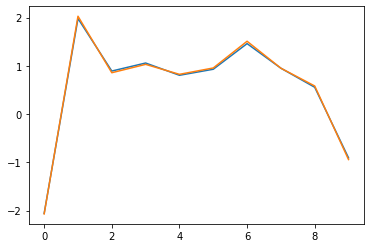

In [9]:
plt.plot(mcmc_mean)
plt.plot(vifa_mean)
plt.show()

In [10]:
def plot_covar(covar: np.ndarray):
    covar_ = np.copy(covar)
    np.fill_diagonal(covar_, 0)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

    cmap = plt.cm.seismic
    img = ax.imshow(covar_, cmap=cmap)

    low, hig = centerColorMap([ax], cmap)
    remove([ax], ["xlabel", "xticks", "yticks"])
    magnitude = int(np.log10(max(abs(low), abs(hig))))

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    formatter = tk.FuncFormatter(lambda x, pos: "%1.1f" % (x / 10 ** magnitude))
    fig.colorbar(img, cax=cbar_ax, format=formatter)

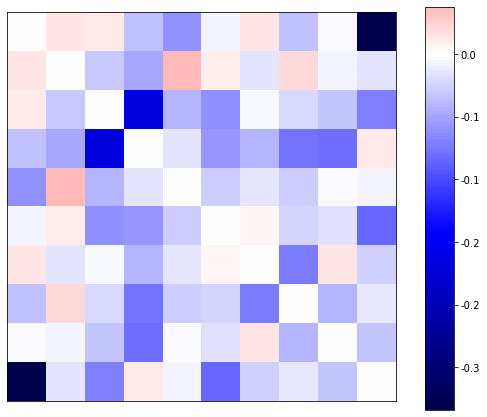

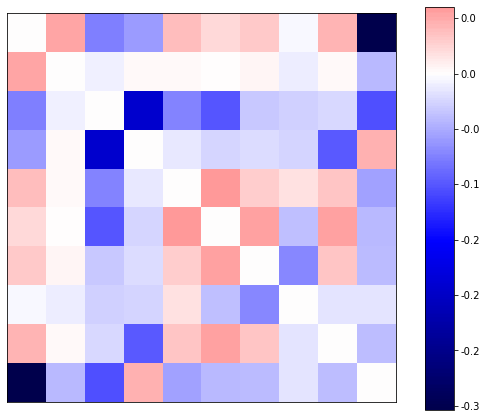

In [12]:
plot_covar(mcmc_cov)
plot_covar(vifa_cov)

### SLANG plotting utils

Copied from https://github.com/aaronpmishkin/SLANG/blob/2563276dedf4d18c77f3195e8645d3133be8d14c/code/python/libs/vi_lib/lib/utilities/plotting.py

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

'''
Assorted helper functions for nice plotting
'''

def forceAspect(ax, aspect=1):
    r"""Forces an axis to an aspect ratio (width/height)."""
    scale_str = ax.get_yaxis().get_scale()
    
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()

    if scale_str=='linear':
        asp = abs((xmax-xmin)/(ymax-ymin))/aspect
    elif scale_str=='log':
        asp = abs((np.log(xmax)-np.log(xmin))/(np.log(ymax)-np.log(ymin)))/aspect

    ax.set_aspect(asp)

def remove(axes, elements):
    for elem in elements:
        assert elem in ["xlabel", "ylabel", "xticks", "yticks"]
        
    for elem in elements:
        for ax in axes:
            if elem is "xlabel":
                ax.set_xlabel("")
            if elem is "ylabel":
                ax.set_ylabel("")
            if elem is "xticks":
                ax.set_xticks([])
            if elem is "yticks":
                ax.set_yticks([])
    
def sync_lims(axes, lim_name):
    r"""
    Make all axes have the same min/max in the desired limits.
    :code:`lim_name` can be `xlims`, `ylims`, `clims`.
    """
    assert lim_name in ['x', 'y', 'c']
    
    def get_lims(ax):
        if lim_name is 'x':
            return ax.get_xlim()
        if lim_name is 'y':
            return ax.get_ylim()
        if lim_name is 'c':
            return ax.images[0].get_clim()

    def set_lim(ax, low, hig):
        if lim_name is 'x':
            return ax.set_xlim(low, hig)
        if lim_name is 'y':
            return ax.set_ylim(low, hig)
        if lim_name is 'c':
            return ax.images[0].set_clim(low, hig)

    lims = np.zeros((len(axes), 2))
    for i in range(len(axes)):
        current_lims = np.array(get_lims(axes[i]))
        lims[i, :] = current_lims
    low, hig = np.min(lims), np.max(lims)
    for ax in axes:
        set_lim(ax, low, hig)

    return low, hig

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.
    Source: https://stackoverflow.com/a/20528097/1983613
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

def centeredSymmetricColorMap(cmap, low, high, name="centeredsymmetricsmap2"):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    
    assert(high > 0)
    assert(low < 0)

    if abs(low) > high:
        start=0
        stop=0.5 + high/(2*abs(low))
    else:
        start=0.5 + low/(2*abs(high))
        stop=1

    reg_index = np.linspace(start, stop, 257)
    shift_index = np.linspace(0.0, 1.0, 129+128, endpoint=True)
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

    
def centerColorMap(axes, cmap):
    low, hig = sync_lims(axes, 'c')
    shrunk_cmap = centeredSymmetricColorMap(cmap, low, hig, name='shrunk')
    for ax in axes:
        ax.get_images()[0].set_cmap(shrunk_cmap)
    return low, hig

def plotPerfectCorrelation(ax, linespec='k--'):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    newlims = [min(min(xlims), min(ylims)), max(max(xlims), max(ylims))]
    ax.plot(newlims, newlims, linespec)
    ax.set_xlim(newlims)
    ax.set_ylim(newlims)

def hide_label_and_tickmark(axis):
    axis.set_ticklabels([])
    axis.set_tick_params(length=0)

def shaded_cov(ax, x, mean, std, **kwargs):
    low = mean - std/np.sqrt(10)
    high = mean + std/np.sqrt(10)
    ax.fill_between(x, low, high, **kwargs)

<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: S